In [1]:
import torch
import numpy as np
import pickle
import pandas as pd
from copy import deepcopy
import absl.app
import absl.flags
import sys
from conservative_sac import ConservativeSAC
from replay_buffer import batch_to_torch, get_d4rl_dataset, subsample_batch
from model import TanhGaussianPolicy, FullyConnectedQFunction, SamplerPolicy
from sampler import StepSampler, TrajSampler
from utils import Timer, define_flags_with_default, set_random_seed, print_flags, get_user_flags, prefix_metrics
from utils import WandBLogger
from viskit.logging_ import logger, setup_logger
import pickle
import pandas as pd

Failed to get python-future


No module named 'future'
/home/fn/anaconda3/envs/py37/lib/python3.7/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
pybullet build time: May 20 2022 19:43:01


In [2]:
import random
def get_sepsis_dataset_val(eval_n_trajs,deterministic=False, replay_buffer=None):
    dataset_path = f'/home/fn/Mynew_Spesis/sepsisrl-master/Decision_trans/decision-transformer-master/gym/my_cql_new_val_df.pkl'
    with open(dataset_path, 'rb') as f:
        trajectories = pickle.load(f)
    trajectories = random.sample(trajectories,eval_n_trajs)

    return trajectories

In [3]:
observation_dim = 48
action_dim = 2
policy_arch = '256-256'
policy_log_std_multiplier = 1.0
policy_log_std_offset = -1.0
orthogonal_init = False
qf_arch = '256-256'
cql=ConservativeSAC.get_default_config()
policy = TanhGaussianPolicy(
    observation_dim,
    action_dim,
    arch=policy_arch,
    log_std_multiplier=policy_log_std_multiplier,
    log_std_offset=policy_log_std_offset,
    orthogonal_init=orthogonal_init,
)

qf1 = FullyConnectedQFunction(
    observation_dim,
    action_dim,
    arch=qf_arch,
    orthogonal_init=orthogonal_init,
)
target_qf1 = deepcopy(qf1)

qf2 = FullyConnectedQFunction(
    observation_dim,
    action_dim,
    arch=qf_arch,
    orthogonal_init=orthogonal_init,
)
target_qf2 = deepcopy(qf2) 

sac = ConservativeSAC(cql, policy, qf1, qf2, target_qf1, target_qf2)
sac.torch_to_device('cuda')

In [4]:
sac = torch.load("/home/fn/Mynew_Spesis/sepsisrl-master/CQL/CQL-master/d4rl/examples/My_model/cql_model.pt")


In [5]:
def sample(valpath,policy, n_trajs, deterministic=False, replay_buffer=None):
        trajs = []
        for i in range(n_trajs):
            observations = []
            actions_cql = []
            actions_py = []
            rewards = []
            next_observations = []
            dones = []

            observation = valpath[i]['observations']
            action = valpath[i]['actions']
            reward = valpath[i]['rewards']
            done = valpath[i]['terminals']
            length = len(observation)
            # print(observation[0]) # observation数据类型有问题
            for j in range(length):
                action_cql = policy(
                    np.expand_dims(np.array(observation[j]), 0), deterministic=deterministic
                )[0, :]
                if j < length-1:
                    next_observation = observation[j+1]
                    observations.append(observation[j])
                    actions_cql.append(action_cql.tolist())
                    actions_py.append(action[j])
                    rewards.append(reward[j])
                    dones.append(done[j])
                    next_observations.append(next_observation)

                if done[j]:
                    break

            trajs.append(dict(
                observations=np.array(observations, dtype=np.float32),
                actions_py=np.array(actions_py, dtype=np.float32),
                rewards=np.array(rewards, dtype=np.float32),
                next_observations=np.array(next_observations, dtype=np.float32),
                dones=np.array(dones, dtype=np.float32),
                actions_cql=np.array(actions_cql, dtype=np.float32),
            ))

        return trajs

In [6]:
eval_n_trajs = 1000
max_traj_length=1000
trajs  = get_sepsis_dataset_val(eval_n_trajs)  # 获得数据

In [7]:
sampler_policy = SamplerPolicy(policy, 'cuda')
trajs = sample(trajs,sampler_policy, eval_n_trajs, deterministic=True)

In [8]:
action_cql = []
action_ph = []
for j in range(len(trajs)):
    actions_ph = trajs[j]['actions_py'].tolist()
    actions_cql = trajs[j]['actions_cql'].tolist()
    action_cql.append(actions_cql)
    action_ph.append(actions_ph)


In [9]:
def get_iv_vaso(actions):
    ac_dt_iv = []
    ac_dt_vaso = []
    for i in range(len(actions)):
        lt = actions[i]
        for j in range(len(lt)):
            w = lt[j]
            ac_dt_iv.append(w[0]*2000)
            if w[1]<0:
                w[1]=0
            ac_dt_vaso.append(w[1])
    return ac_dt_iv,ac_dt_vaso

In [10]:
ac_cql_iv,ac_cql_vaso=get_iv_vaso(action_cql)
ac_py_iv,ac_py_vaso=get_iv_vaso(action_ph)

In [22]:
print(action_cql)

[[[0.00015879800776019692, 0], [0.00010169143206439912, 0], [7.10084568709135e-05, 0], [-0.0001896550238598138, 0], [8.659830200485885e-05, 0], [-5.424313712865114e-06, 0], [4.391768015921116e-08, 0], [0.00012364104622974992, 0], [-0.0001140886452049017, 0], [-0.00011710842954926193, 0], [-4.25174948759377e-06, 0], [-2.2872351109981537e-05, 0], [-4.782795440405607e-05, 0], [-8.408812573179603e-05, 0], [4.243047442287207e-06, 0], [-2.835324266925454e-05, 0], [-1.2174248695373535e-05, 0], [-5.7212921092286706e-05, 0], [-2.6760506443679333e-05, 0]], [[0.0003386893658898771, 0], [0.0006979410536587238, 0], [0.0006502288160845637, 0], [0.0006064820918254554, 0], [0.0006196926697157323, 0], [0.0006537711014971137, 0], [0.0006690718000754714, 0], [0.0006849169731140137, 0], [0.0006875882390886545, 0], [0.0007913768058642745, 0], [0.0007016079034656286, 0]], [[-6.567605305463076e-05, 0], [-8.502270793542266e-05, 0], [-0.00013731856597587466, 0], [-0.00014904883573763072, 0], [-0.00014263368211

In [21]:
print(ac_cql_iv)

[0.31759601552039385, 0.20338286412879825, 0.142016913741827, -0.3793100477196276, 0.1731966040097177, -0.010848627425730228, 8.783536031842232e-05, 0.24728209245949984, -0.2281772904098034, -0.23421685909852386, -0.00850349897518754, -0.045744702219963074, -0.09565590880811214, -0.16817625146359205, 0.008486094884574413, -0.05670648533850908, -0.02434849739074707, -0.11442584218457341, -0.053521012887358665, 0.6773787317797542, 1.3958821073174477, 1.3004576321691275, 1.2129641836509109, 1.2393853394314647, 1.3075422029942274, 1.3381436001509428, 1.3698339462280273, 1.375176478177309, 1.582753611728549, 1.4032158069312572, -0.1313521061092615, -0.17004541587084532, -0.2746371319517493, -0.29809767147526145, -0.2852673642337322, 0.010022486094385386, 0.017063342966139317, -0.26711157988756895, -0.253974343650043, -0.15251414151862264, -0.022481661289930344, 0.22524280939251184, 1.6343436436727643, 1.7253539990633726, 1.768613699823618, 1.7239006701856852, 1.5255003236234188, 1.639364869

In [12]:
print(ac_cql_vaso)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

<AxesSubplot:ylabel='Frequency'>

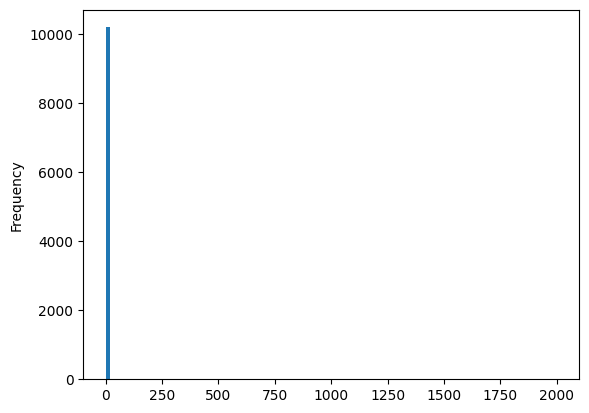

In [13]:
pd.Series(ac_cql_iv).plot.hist(range=[0,2000],bins=100)

<AxesSubplot:ylabel='Frequency'>

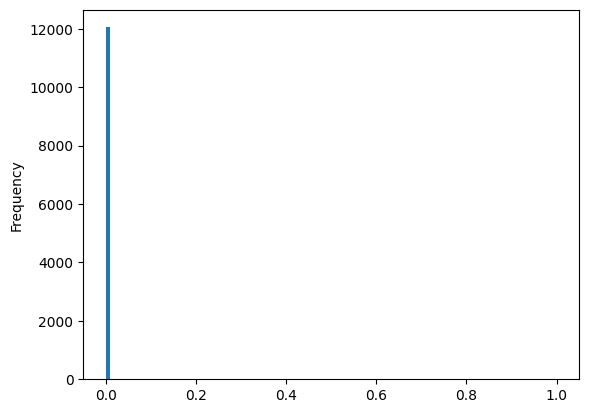

In [23]:
pd.Series(ac_cql_vaso).plot.hist(range=[0,1],bins=100)

In [15]:
_agent = pd.DataFrame(columns=['iv','vaso','ivt','vasot'])
_phy = pd.DataFrame(columns=['iv','vaso','ivt','vasot'])
_agent['iv'] = ac_cql_iv
_agent['vaso'] = ac_cql_vaso
_phy['iv'] = ac_py_iv
_phy['vaso'] = ac_py_vaso

In [16]:
print(_agent)

             iv  vaso  ivt vasot
0      0.317596     0  NaN   NaN
1      0.203383     0  NaN   NaN
2      0.142017     0  NaN   NaN
3     -0.379310     0  NaN   NaN
4      0.173197     0  NaN   NaN
...         ...   ...  ...   ...
12044 -0.289365     0  NaN   NaN
12045  0.043322     0  NaN   NaN
12046  0.087959     0  NaN   NaN
12047  0.670510     0  NaN   NaN
12048  0.109054     0  NaN   NaN

[12049 rows x 4 columns]


In [17]:
vq = np.array([0.08,0.2,0.45])
ivq = np.array([48,150,500])

_agent['vasot'][_agent['vaso'] <= 0.0] = 0
_agent['vasot'][(_agent['vaso'] > 0.0) & (_agent['vaso'] < vq[0])] = 1
_agent['vasot'][(_agent['vaso'] >= vq[0]) & (_agent['vaso'] < vq[1])] = 2
_agent['vasot'][(_agent['vaso'] >= vq[1]) & (_agent['vaso'] < vq[2])] = 3
_agent['vasot'][_agent['vaso'] >= vq[2]] = 4

_phy['vasot'][_phy['vaso'] <= 0.0] = 0
_phy['vasot'][(_phy['vaso'] > 0.0) & (_phy['vaso'] < vq[0])] = 1
_phy['vasot'][(_phy['vaso'] >= vq[0]) & (_phy['vaso'] < vq[1])] = 2
_phy['vasot'][(_phy['vaso'] >= vq[1]) & (_phy['vaso'] < vq[2])] = 3
a = _phy['vaso'] >= vq[2]
_phy['vasot'][a] = 4

_agent['ivt'][_agent['iv'] < 1.0] = 0
_agent['ivt'][(_agent['iv'] >= 1.0) & (_agent['iv'] < ivq[0])] = 1
_agent['ivt'][(_agent['iv'] >= ivq[0]) & (_agent['iv'] < ivq[1])] = 2
_agent['ivt'][(_agent['iv'] >= ivq[1]) & (_agent['iv'] < ivq[2])] = 3
a = _agent['iv'] >= ivq[2]
_agent['ivt'][a] = 4

_phy['ivt'][_phy['iv'] == 0.0] = 0
_phy['ivt'][(_phy['iv'] > 0.0) & (_phy['iv'] < ivq[0])] = 1
_phy['ivt'][(_phy['iv'] >= ivq[0]) & (_phy['iv'] < ivq[1])] = 2
_phy['ivt'][(_phy['iv'] >= ivq[1]) & (_phy['iv'] < ivq[2])] = 3
a = _phy['iv'] >= ivq[2]
_phy['ivt'][a] = 4

/home/fn/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/fn/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/fn/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/fn/ana

In [18]:
agent_iv = _agent['ivt']
agent_vaso = _agent['vasot']
phy_iv = _phy['ivt']
phy_vaso = _phy['vasot']
hist1, _, _ = np.histogram2d(phy_iv, phy_vaso, bins=5)
hist2, _, _ = np.histogram2d(agent_iv, agent_vaso, bins=5)

x_edges = np.arange(-0.5,5)
y_edges = np.arange(-0.5,5)

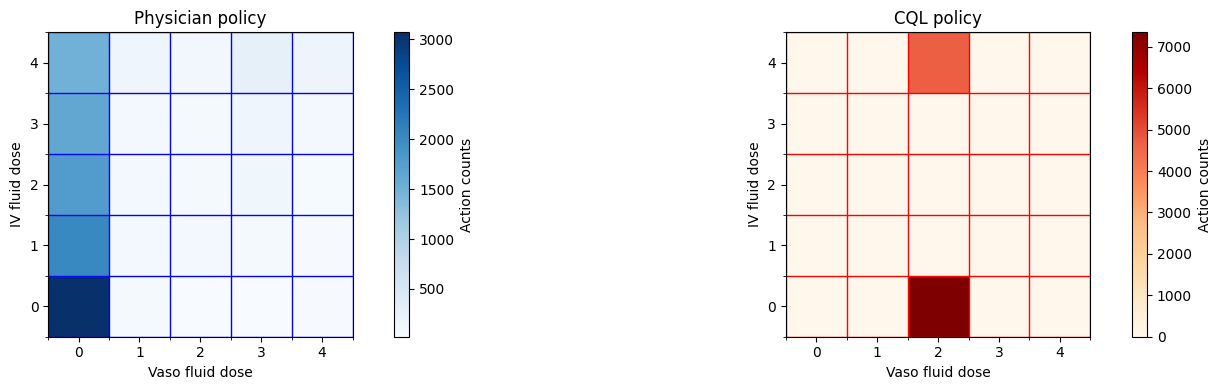

In [20]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
ax1.imshow(np.flipud(hist1), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])
ax2.imshow(np.flipud(hist2), cmap="OrRd", extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])

ax1.set_xticks(np.arange(0, 5, 1));
ax1.set_yticks(np.arange(0, 5, 1));
ax2.set_xticks(np.arange(0, 5, 1));
ax2.set_yticks(np.arange(0, 5, 1));

ax1.set_xticklabels(np.arange(0, 5, 1));
ax1.set_yticklabels(np.arange(0, 5, 1));
ax2.set_xticklabels(np.arange(0, 5, 1));
ax2.set_yticklabels(np.arange(0, 5, 1));

ax1.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax1.set_yticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_xticks(np.arange(-.5, 5, 1), minor=True);
ax2.set_yticks(np.arange(-.5, 5, 1), minor=True);

ax1.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax2.grid(which='minor', color='r', linestyle='-', linewidth=1)

im1 = ax1.pcolormesh(x_edges, y_edges, hist1, cmap='Blues')
f.colorbar(im1, ax=ax1, label = "Action counts")

im2 = ax2.pcolormesh(x_edges, y_edges, hist2, cmap='OrRd')
f.colorbar(im2, ax=ax2, label = "Action counts")

ax1.set_ylabel('IV fluid dose')
ax2.set_ylabel('IV fluid dose')
ax1.set_xlabel('Vaso fluid dose')
ax2.set_xlabel('Vaso fluid dose')

ax1.set_title("Physician policy")
ax2.set_title("CQL policy")

plt.tight_layout()